# Testing U-net testing Malaria Images

Testing U-net with images of P. vivax (malaria) infected human blood smears

https://www.kaggle.com/kmader/malaria-bounding-boxes

In [3]:
import tensorflow as tf            
import pandas as pd                 
import numpy as np                                       
import sklearn.model_selection     # For using KFold
import keras.preprocessing.image   # For using image generation
import datetime                    # To measure running time 
import skimage.transform           # For resizing images
import skimage.morphology          # For using image labeling
import cv2                         # To read and manipulate images
import os                          # For filepath, directory handling
import sys                         # System-specific parameters and functions
import tqdm                        # Use smart progress meter
import seaborn as sns              # For pairplots
import matplotlib.pyplot as plt    # Python 2D plotting library
import matplotlib.cm as cm         # Color map
%matplotlib inline                  

Using TensorFlow backend.


## Loading Images

### Parameters

In [17]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

TRAIN_PATH = '../../data/raw_data/malaria/transformed_images/'
TEST_PATH = 'stage1_test/'
LOGS_DIR_NAME = 'logs' 
SAVES_DIR_NAME = 'saves'

#MASK_CATEGORIES = ['trophozoite','ring', 'schizont', 'gametocyte']
MASK_CATEGORIES = ['trophozoite']
STR_MASK_CATEGORIES = '_'.join(MASK_CATEGORIES)

min_object_size = 1 
CW_DIR = os.getcwd()

In [18]:
str_masks_name = '_'.join(MASK_CATEGORIES)

In [19]:
train_ids = np.load(TRAIN_PATH+'malaria_train_transformed_256_256_names.npy',allow_pickle=True)
X_train = np.load(TRAIN_PATH+'malaria_train_transformed_256_256.npy',allow_pickle=True)
Y_train =  np.load(TRAIN_PATH+'malaria_train_transformed_256_256_masks_'+STR_MASK_CATEGORIES+'.npy',allow_pickle=True)

In [55]:
test_ids = np.load(TRAIN_PATH+'malaria_test_transformed_256_256_names.npy',allow_pickle=True)
X_test = np.load(TRAIN_PATH+'malaria_test_transformed_256_256.npy',allow_pickle=True)
Y_test =  np.load(TRAIN_PATH+'malaria_test_transformed_256_256_masks_'+STR_MASK_CATEGORIES+'.npy',allow_pickle=True)

In [21]:
print(X_train.shape)
print(Y_train.shape)

(1208, 256, 256, 3)
(1208, 256, 256, 1)


In [22]:
print(X_test.shape)
print(Y_test.shape)

(120, 256, 256, 3)
(120, 256, 256, 1)


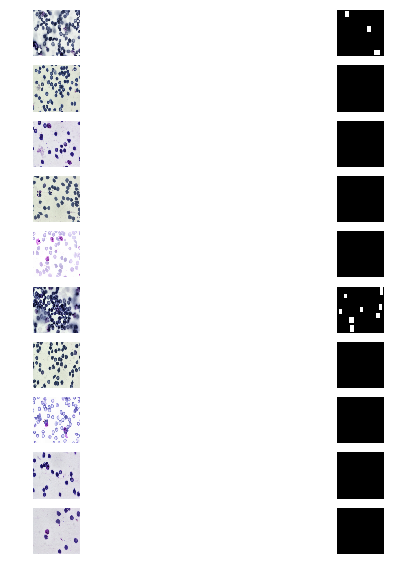

In [23]:
n_images = 10

fig, axes = plt.subplots(n_images,2,figsize=(10,10))
for i in range(n_images):
    #ix = random.randint(0, len(train_ids))
    ix = i
    axes[i,0].imshow(X_train[ix])
    axes[i,1].imshow(np.squeeze(Y_train[ix]), cmap='gray')

fig = plt.gcf()
for ax in fig.axes:
    ax.axis('off')

plt.show()

### BALANCE DATA SET

In [24]:
n_images = train_ids.shape[0]

count_no_mask = 0
count_img_mask = 0
rand_filter_count = 0
delete_index = []

for i in range(n_images):
    #ix = random.randint(0, len(train_ids))
    if (np.sum(Y_train[i].reshape(-1)) > 0):
        count_img_mask += 1
    else:
        count_no_mask += 1
        if (np.random.rand(1) > 1 ):
            rand_filter_count += 1
        else:
            delete_index.append(i)
        

print("Total images: " + str(n_images))
print("Total images without masks: " + str(count_no_mask))
print("Total images without masks with filter: " + str(rand_filter_count))
print("Total images with masks: " + str(count_img_mask))
print(len(delete_index))

Total images: 1208
Total images without masks: 612
Total images without masks with filter: 0
Total images with masks: 596
612


In [25]:
X_train_balanced = np.delete(X_train, delete_index, 0)
Y_train_balanced = np.delete(Y_train, delete_index, 0)

In [11]:
print(X_train_balanced.shape)
print(Y_train_balanced.shape)

(596, 256, 256, 3)
(596, 256, 256, 1)


### IoU (Intersection of the union)
The intersection of the union(IOU): Measure the total number of shared pixels after applying the masks

\begin{equation*}
  IOU = \frac{I_1 \cup I_2}{I_1 \cap I_2}
\end{equation*}

In [10]:
def get_labeled_mask(mask, cutoff=.5):
    """Object segmentation by labeling the mask."""
    mask = mask.reshape(mask.shape[0], mask.shape[1])
    lab_mask = skimage.morphology.label(mask > cutoff) 
    
    # Keep only objects that are large enough.
    (mask_labels, mask_sizes) = np.unique(lab_mask, return_counts=True)
    if (mask_sizes < min_object_size).any():
        mask_labels = mask_labels[mask_sizes < min_object_size]
        for n in mask_labels:
            lab_mask[lab_mask == n] = 0
        lab_mask = skimage.morphology.label(lab_mask > cutoff) 
    
    return lab_mask  

In [11]:
def get_iou(y_true_labeled, y_pred_labeled):
    """Compute non-zero intersections over unions."""
    # Array of different objects and occupied area.
    (true_labels, true_areas) = np.unique(y_true_labeled, return_counts=True)
    (pred_labels, pred_areas) = np.unique(y_pred_labeled, return_counts=True)

    # Number of different labels.
    n_true_labels = len(true_labels)
    n_pred_labels = len(pred_labels)

    # Each mask has at least one identified object.
    if (n_true_labels > 1) and (n_pred_labels > 1):
        
        # Compute all intersections between the objects.
        all_intersections = np.zeros((n_true_labels, n_pred_labels))
        for i in range(y_true_labeled.shape[0]):
            for j in range(y_true_labeled.shape[1]):
                m = y_true_labeled[i,j]
                n = y_pred_labeled[i,j]
                all_intersections[m,n] += 1 

        # Assign predicted to true background.
        assigned = [[0,0]]
        tmp = all_intersections.copy()
        tmp[0,:] = -1
        tmp[:,0] = -1

        # Assign predicted to true objects if they have any overlap.
        for i in range(1, np.min([n_true_labels, n_pred_labels])):
            mn = list(np.unravel_index(np.argmax(tmp), (n_true_labels, n_pred_labels)))
            if all_intersections[mn[0], mn[1]] > 0:
                assigned.append(mn)
            tmp[mn[0],:] = -1
            tmp[:,mn[1]] = -1
        assigned = np.array(assigned)

        # Intersections over unions.
        intersection = np.array([all_intersections[m,n] for m,n in assigned])
        union = np.array([(true_areas[m] + pred_areas[n] - all_intersections[m,n]) 
                           for m,n in assigned])
        iou = intersection / union

        # Remove background.
        iou = iou[1:]
        assigned = assigned[1:]
        true_labels = true_labels[1:]
        pred_labels = pred_labels[1:]

        # Labels that are not assigned.
        true_not_assigned = np.setdiff1d(true_labels, assigned[:,0])
        pred_not_assigned = np.setdiff1d(pred_labels, assigned[:,1])
        
    else:
        # in case that no object is identified in one of the masks
        iou = np.array([])
        assigned = np.array([])
        true_labels = true_labels[1:]
        pred_labels = pred_labels[1:]
        true_not_assigned = true_labels
        pred_not_assigned = pred_labels
        
    # Returning parameters.
    params = {'iou': iou, 'assigned': assigned, 'true_not_assigned': true_not_assigned,
             'pred_not_assigned': pred_not_assigned, 'true_labels': true_labels,
             'pred_labels': pred_labels}
    return params

def get_score_summary(y_true, y_pred):
    """Compute the score for a single sample including a detailed summary."""
    
    y_true_labeled = get_labeled_mask(y_true)  
    y_pred_labeled = get_labeled_mask(y_pred) 
    
    params = get_iou(y_true_labeled, y_pred_labeled)
    iou = params['iou']
    assigned = params['assigned']
    true_not_assigned = params['true_not_assigned']
    pred_not_assigned = params['pred_not_assigned']
    true_labels = params['true_labels']
    pred_labels = params['pred_labels']
    n_true_labels = len(true_labels)
    n_pred_labels = len(pred_labels)

    summary = []
    for i,threshold in enumerate(np.arange(0.5, 1.0, 0.05)):
        tp = np.sum(iou > threshold)
        fn = n_true_labels - tp
        fp = n_pred_labels - tp
        if (tp+fp+fn)>0: 
            prec = tp/(tp+fp+fn)
        else: 
            prec = 0
        summary.append([threshold, prec, tp, fp, fn])

    summary = np.array(summary)
    score = np.mean(summary[:,1]) # Final score.
    params_dict = {'summary': summary, 'iou': iou, 'assigned': assigned, 
                   'true_not_assigned': true_not_assigned, 
                   'pred_not_assigned': pred_not_assigned, 'true_labels': true_labels,
                   'pred_labels': pred_labels, 'y_true_labeled': y_true_labeled,
                   'y_pred_labeled': y_pred_labeled}
    
    return score, params_dict

def get_score(y_true, y_pred):
    """Compute the score for a batch of samples."""
    scores = []
    for i in range(len(y_true)):
        score,_ = get_score_summary(y_true[i], y_pred[i])
        scores.append(score)
    return np.array(scores)


In [14]:
def get_metrics_grafics(results):
    # 'val_loss', 'val_my_iou_metric', 'loss', 'iou_loss_core'
    plt.figure(figsize=(20,10))
    ## LOSS
    plt.subplot(221)
    plt.plot(results.history['loss'], label='Training loss')
    plt.plot(results.history['val_loss'], label='Validation loss')
    plt.legend(frameon=False)
    ## Intersection over union
    plt.subplot(222)
    plt.plot(results.history['iou_loss_core'], label='Training IoU')
    plt.plot(results.history['val_iou_loss_core'], label='Validation IoU')
    plt.legend(frameon=False)

    plt.show()

In [15]:
def trsf_proba_to_binary(y_data):
    """Transform propabilities into binary values 0 or 1."""  
    return np.greater(y_data,.5).astype(np.uint8)

def imshow_args(x):
    """Matplotlib imshow arguments for plotting."""
    if len(x.shape)==2: return x, cm.gray
    if x.shape[2]==1: return x[:,:,0], cm.gray
    return x, None

## U-Net

![title](../../u-net-architecture.png)

In [50]:
class NeuralNetwork():
    """ Implements a neural network.
        
        TensorFlow is used to implement the U-Net, which consists of convolutional
        and max pooling layers. Input and output shapes coincide. Methods are
        implemented to train the model, to save/load the complete session and to 
        attach summaries for visualization with TensorBoard. 
    """

    def __init__(self, nn_name='tmp', nn_type='UNet', log_step=0.2, keep_prob=0.33, 
                 mb_size=16, input_shape=[IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS], 
                 output_shape=[IMG_HEIGHT,IMG_WIDTH,1]):
        """Instance constructor."""
        
        # Tunable hyperparameters for training.
        self.mb_size = mb_size       # Mini batch size
        self.keep_prob = keep_prob   # Keeping probability with dropout regularization 
        self.learn_rate_step = 3     # Step size in terms of epochs
        self.learn_rate_alpha = 0.25 # Reduction of learn rate for each step 
        self.learn_rate_0 = 0.001    # Starting learning rate 
        self.dropout_proba = 0.1     # == 1-keep_probability
        
        # Set helper variables.
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.nn_type = nn_type                # Type of neural network
        self.nn_name = nn_name                # Name of neural network
        self.params = {}                      # For storing parameters
        self.learn_rate_pos = 0                
        self.learn_rate = self.learn_rate_0
        self.index_in_epoch = 0 
        self.epoch = 0. 
        self.log_step = log_step              # Log results in terms of epochs
        self.n_log_step = 0                   # Count number of mini batches  
        self.train_on_augmented_data = False  # True = use augmented data 
        self.use_tb_summary = False           # True = use TensorBoard summaries
        self.use_tf_saver = False             # True = save the session
        
        # Parameters that should be stored.
        self.params['train_loss']=[]
        self.params['valid_loss']=[]
        self.params['train_score']=[]
        self.params['valid_score']=[]
        
    def get_learn_rate(self):
        """Compute the current learning rate."""
        if False:
            # Fixed learnrate
            learn_rate = self.learn_rate_0
        else:
            # Decreasing learnrate each step by factor 1-alpha
            learn_rate = self.learn_rate_0*(1.-self.learn_rate_alpha)**self.learn_rate_pos
        return learn_rate

    def next_mini_batch(self):
        """Get the next mini batch."""
        start = self.index_in_epoch
        self.index_in_epoch += self.mb_size           
        self.epoch += self.mb_size/len(self.x_train)
        
        # At the start of the epoch.
        if start == 0:
            np.random.shuffle(self.perm_array) # Shuffle permutation array.
   
        # In case the current index is larger than one epoch.
        if self.index_in_epoch > len(self.x_train):
            self.index_in_epoch = 0
            self.epoch -= self.mb_size/len(self.x_train) 
            return self.next_mini_batch() # Recursive use of function.
        
        end = self.index_in_epoch
        
        # Original data.
        x_tr = self.x_train[self.perm_array[start:end]]
        y_tr = self.y_train[self.perm_array[start:end]]
        
        # Use augmented data.
        if self.train_on_augmented_data:
            x_tr, y_tr = generate_images_and_masks(x_tr, y_tr)
            y_tr = trsf_proba_to_binary(y_tr)
        
        return x_tr, y_tr
 
    def weight_variable(self, shape, name=None):
        """ Weight initialization """
        #initializer = tf.truncated_normal(shape, stddev=0.1)
        initializer = tf.contrib.layers.xavier_initializer()
        #initializer = tf.contrib.layers.variance_scaling_initializer()
        return tf.get_variable(name, shape=shape, initializer=initializer)

    def bias_variable(self, shape, name=None):
        """Bias initialization."""
        #initializer = tf.constant(0.1, shape=shape)  
        initializer = tf.contrib.layers.xavier_initializer()
        #initializer = tf.contrib.layers.variance_scaling_initializer()
        return tf.get_variable(name, shape=shape, initializer=initializer)
     
    def conv2d(self, x, W, name=None):
        """ 2D convolution. """
        return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME', name=name)

    def max_pool_2x2(self, x, name=None):
        """ Max Pooling 2x2. """
        return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME',
                              name=name)
    
    def conv2d_transpose(self, x, filters, name=None):
        """ Transposed 2d convolution. """
        return tf.layers.conv2d_transpose(x, filters=filters, kernel_size=2, 
                                          strides=2, padding='SAME') 
    
    def leaky_relu(self, z, name=None):
        """Leaky ReLU."""
        return tf.maximum(0.01 * z, z, name=name)
    
    def activation(self, x, name=None):
        """ Activation function. """
        a = tf.nn.elu(x, name=name)
        #a = self.leaky_relu(x, name=name)
        #a = tf.nn.relu(x, name=name)
        return a 
    
    def loss_tensor(self):
        """Loss tensor."""
        if True:
            # Dice loss based on Jaccard dice score coefficent.
            axis=np.arange(1,len(self.output_shape)+1)
            offset = 1e-5
            corr = tf.reduce_sum(self.y_data_tf * self.y_pred_tf, axis=axis)
            l2_pred = tf.reduce_sum(tf.square(self.y_pred_tf), axis=axis)
            l2_true = tf.reduce_sum(tf.square(self.y_data_tf), axis=axis)
            dice_coeff = (2. * corr + 1e-5) / (l2_true + l2_pred + 1e-5)
            # Second version: 2-class variant of dice loss
            #corr_inv = tf.reduce_sum((1.-self.y_data_tf) * (1.-self.y_pred_tf), axis=axis)
            #l2_pred_inv = tf.reduce_sum(tf.square(1.-self.y_pred_tf), axis=axis)
            #l2_true_inv = tf.reduce_sum(tf.square(1.-self.y_data_tf), axis=axis)
            #dice_coeff = ((corr + offset) / (l2_true + l2_pred + offset) +
            #             (corr_inv + offset) / (l2_pred_inv + l2_true_inv + offset))
            loss = tf.subtract(1., tf.reduce_mean(dice_coeff))
        if False:
            # Sigmoid cross entropy. 
            loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=self.y_data_tf, logits=self.z_pred_tf))
        return loss 
    
    def optimizer_tensor(self):
        """Optimization tensor."""
        # Adam Optimizer (adaptive moment estimation). 
        optimizer = tf.train.AdamOptimizer(self.learn_rate_tf).minimize(
                    self.loss_tf, name='train_step_tf')
        return optimizer
   
    def batch_norm_layer(self, x, name=None):
        """Batch normalization layer."""
        if False:
            layer = tf.layers.batch_normalization(x, training=self.training_tf, 
                                                  momentum=0.9, name=name)
        else: 
            layer = x
        return layer
    
    def dropout_layer(self, x, name=None):
        """Dropout layer."""
        if False:
            layer = tf.layers.dropout(x, self.dropout_proba, training=self.training_tf,
                                     name=name)
        else:
            layer = x
        return layer

    def num_of_weights(self,tensors):
        """Compute the number of weights."""
        sum_=0
        for i in range(len(tensors)):
            m = 1
            for j in range(len(tensors[i].shape)):
              m *= int(tensors[i].shape[j])
            sum_+=m
        return sum_

    def build_UNet_graph(self):
        """ Create the UNet graph in TensorFlow. """
        # 1. unit 
        with tf.name_scope('1.unit'):
            W1_1 = self.weight_variable([3,3,self.input_shape[2],16], 'W1_1')
            b1_1 = self.bias_variable([16], 'b1_1')
            Z1 = self.conv2d(self.x_data_tf, W1_1, 'Z1') + b1_1
            A1 = self.activation(self.batch_norm_layer(Z1)) # (.,128,128,16)
            A1_drop = self.dropout_layer(A1)
            W1_2 = self.weight_variable([3,3,16,16], 'W1_2')
            b1_2 = self.bias_variable([16], 'b1_2')
            Z2 = self.conv2d(A1_drop, W1_2, 'Z2') + b1_2
            A2 = self.activation(self.batch_norm_layer(Z2)) # (.,128,128,16)
            P1 = self.max_pool_2x2(A2, 'P1') # (.,64,64,16)
        # 2. unit 
        with tf.name_scope('2.unit'):
            W2_1 = self.weight_variable([3,3,16,32], "W2_1")
            b2_1 = self.bias_variable([32], 'b2_1')
            Z3 = self.conv2d(P1, W2_1) + b2_1
            A3 = self.activation(self.batch_norm_layer(Z3)) # (.,64,64,32)
            A3_drop = self.dropout_layer(A3)
            W2_2 = self.weight_variable([3,3,32,32], "W2_2")
            b2_2 = self.bias_variable([32], 'b2_2')
            Z4 = self.conv2d(A3_drop, W2_2) + b2_2
            A4 = self.activation(self.batch_norm_layer(Z4)) # (.,64,64,32)
            P2 = self.max_pool_2x2(A4) # (.,32,32,32)
        # 3. unit
        with tf.name_scope('3.unit'):
            W3_1 = self.weight_variable([3,3,32,64], "W3_1")
            b3_1 = self.bias_variable([64], 'b3_1')
            Z5 = self.conv2d(P2, W3_1) + b3_1
            A5 = self.activation(self.batch_norm_layer(Z5)) # (.,32,32,64)
            A5_drop = self.dropout_layer(A5)
            W3_2 = self.weight_variable([3,3,64,64], "W3_2")
            b3_2 = self.bias_variable([64], 'b3_2')
            Z6 = self.conv2d(A5_drop, W3_2) + b3_2
            A6 = self.activation(self.batch_norm_layer(Z6)) # (.,32,32,64)
            P3 = self.max_pool_2x2(A6) # (.,16,16,64)
        # 4. unit
        with tf.name_scope('4.unit'):
            W4_1 = self.weight_variable([3,3,64,128], "W4_1")
            b4_1 = self.bias_variable([128], 'b4_1')
            Z7 = self.conv2d(P3, W4_1) + b4_1
            A7 = self.activation(self.batch_norm_layer(Z7)) # (.,16,16,128)
            A7_drop = self.dropout_layer(A7)
            W4_2 = self.weight_variable([3,3,128,128], "W4_2")
            b4_2 = self.bias_variable([128], 'b4_2')
            Z8 = self.conv2d(A7_drop, W4_2) + b4_2
            A8 = self.activation(self.batch_norm_layer(Z8)) # (.,16,16,128)
            P4 = self.max_pool_2x2(A8) # (.,8,8,128)
        # 5. unit 
        with tf.name_scope('5.unit'):
            W5_1 = self.weight_variable([3,3,128,256], "W5_1")
            b5_1 = self.bias_variable([256], 'b5_1')
            Z9 = self.conv2d(P4, W5_1) + b5_1
            A9 = self.activation(self.batch_norm_layer(Z9)) # (.,8,8,256)
            A9_drop = self.dropout_layer(A9)
            W5_2 = self.weight_variable([3,3,256,256], "W5_2")
            b5_2 = self.bias_variable([256], 'b5_2')
            Z10 = self.conv2d(A9_drop, W5_2) + b5_2
            A10 = self.activation(self.batch_norm_layer(Z10)) # (.,8,8,256)
        # 6. unit
        with tf.name_scope('6.unit'):
            W6_1 = self.weight_variable([3,3,256,128], "W6_1")
            b6_1 = self.bias_variable([128], 'b6_1')
            U1 = self.conv2d_transpose(A10, 128) # (.,16,16,128)
            U1 = tf.concat([U1, A8], 3) # (.,16,16,256)
            Z11 = self.conv2d(U1, W6_1) + b6_1
            A11 = self.activation(self.batch_norm_layer(Z11)) # (.,16,16,128)
            A11_drop = self.dropout_layer(A11)
            W6_2 = self.weight_variable([3,3,128,128], "W6_2")
            b6_2 = self.bias_variable([128], 'b6_2')
            Z12 = self.conv2d(A11_drop, W6_2) + b6_2
            A12 = self.activation(self.batch_norm_layer(Z12)) # (.,16,16,128)
        # 7. unit 
        with tf.name_scope('7.unit'):
            W7_1 = self.weight_variable([3,3,128,64], "W7_1")
            b7_1 = self.bias_variable([64], 'b7_1')
            U2 = self.conv2d_transpose(A12, 64) # (.,32,32,64)
            U2 = tf.concat([U2, A6],3) # (.,32,32,128)
            Z13 = self.conv2d(U2, W7_1) + b7_1
            A13 = self.activation(self.batch_norm_layer(Z13)) # (.,32,32,64)
            A13_drop = self.dropout_layer(A13)
            W7_2 = self.weight_variable([3,3,64,64], "W7_2")
            b7_2 = self.bias_variable([64], 'b7_2')
            Z14 = self.conv2d(A13_drop, W7_2) + b7_2
            A14 = self.activation(self.batch_norm_layer(Z14)) # (.,32,32,64)
        # 8. unit
        with tf.name_scope('8.unit'):
            W8_1 = self.weight_variable([3,3,64,32], "W8_1")
            b8_1 = self.bias_variable([32], 'b8_1')
            U3 = self.conv2d_transpose(A14, 32) # (.,64,64,32)
            U3 = tf.concat([U3, A4],3) # (.,64,64,64)
            Z15 = self.conv2d(U3, W8_1) + b8_1
            A15 = self.activation(self.batch_norm_layer(Z15)) # (.,64,64,32)
            A15_drop = self.dropout_layer(A15)
            W8_2 = self.weight_variable([3,3,32,32], "W8_2")
            b8_2 = self.bias_variable([32], 'b8_2')
            Z16 = self.conv2d(A15_drop, W8_2) + b8_2
            A16 = self.activation(self.batch_norm_layer(Z16)) # (.,64,64,32)
        # 9. unit 
        with tf.name_scope('9.unit'):
            W9_1 = self.weight_variable([3,3,32,16], "W9_1")
            b9_1 = self.bias_variable([16], 'b9_1')
            U4 = self.conv2d_transpose(A16, 16) # (.,128,128,16)
            U4 = tf.concat([U4, A2],3) # (.,128,128,32)
            Z17 = self.conv2d(U4, W9_1) + b9_1
            A17 = self.activation(self.batch_norm_layer(Z17)) # (.,128,128,16)
            A17_drop = self.dropout_layer(A17)
            W9_2 = self.weight_variable([3,3,16,16], "W9_2")
            b9_2 = self.bias_variable([16], 'b9_2')
            Z18 = self.conv2d(A17_drop, W9_2) + b9_2
            A18 = self.activation(self.batch_norm_layer(Z18)) # (.,128,128,16)
        # 10. unit: output layer
        with tf.name_scope('10.unit'):
            W10 = self.weight_variable([1,1,16,1], "W10")
            b10 = self.bias_variable([1], 'b10')
            Z19 = self.conv2d(A18, W10) + b10
            A19 = tf.nn.sigmoid(self.batch_norm_layer(Z19)) # (.,128,128,1)
        
        self.z_pred_tf = tf.identity(Z19, name='z_pred_tf') # (.,128,128,1)
        self.y_pred_tf = tf.identity(A19, name='y_pred_tf') # (.,128,128,1)
        
        print('Build UNet Graph: 10 layers, {} trainable weights'.format(
            self.num_of_weights([W1_1,b1_1,W1_2,b1_2,W2_1,b2_1,W2_2,b2_2,
                                 W3_1,b3_1,W3_2,b3_2,W4_1,b4_1,W4_2,b4_2,
                                 W5_1,b5_1,W5_2,b5_2,W6_1,b6_1,W6_2,b6_2,
                                 W7_1,b7_1,W7_2,b7_2,W8_1,b8_1,W8_2,b8_2,
                                 W9_1,b9_1,W9_2,b9_2,W10,b10])))
    
    def build_graph(self):
        """ Build the complete graph in TensorFlow. """
        tf.reset_default_graph()  
        self.graph = tf.Graph()

        with self.graph.as_default():
            
            # Input tensor.
            shape = [None]
            shape = shape.extend(self.input_shape)
            self.x_data_tf = tf.placeholder(dtype=tf.float32, shape=shape, 
                                            name='x_data_tf') # (.,128,128,3)
            
            # Generic tensors.
            self.keep_prob_tf = tf.placeholder_with_default(1.0, shape=(), 
                                                            name='keep_prob_tf') 
            self.learn_rate_tf = tf.placeholder(dtype=tf.float32,
                                                name="learn_rate_tf")
            self.training_tf = tf.placeholder_with_default(False, shape=(),
                                                           name='training_tf')
            # Build U-Net graph.
            self.build_UNet_graph()

            # Target tensor.
            shape = [None]
            shape = shape.extend(self.output_shape)
            self.y_data_tf = tf.placeholder(dtype=tf.float32, shape=shape, 
                                            name='y_data_tf') # (.,128,128,1)
            # Loss tensor
            self.loss_tf = tf.identity(self.loss_tensor(), name='loss_tf')

            # Optimisation tensor.
            self.train_step_tf = self.optimizer_tensor()
            
            # Extra operations required for batch normalization.
            self.extra_update_ops_tf = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

            
    def train_graph(self, sess, x_train, y_train, x_valid, y_valid, n_epoch=1, 
                    train_on_augmented_data=False):
        """ Train the graph of the corresponding neural network. """
        # Set training and validation sets.
        self.x_train = x_train
        self.y_train = y_train
        self.x_valid = x_valid
        self.y_valid = y_valid
        
        # Parameters.
        self.perm_array = np.arange(len(self.x_train))
        self.train_on_augmented_data = train_on_augmented_data
        mb_per_epoch = self.x_train.shape[0]/self.mb_size
        train_loss, train_score, valid_loss, valid_score = [],[],[],[]
        
        # Start timer.
        start = datetime.datetime.now()
        print('Training the Neural Network')
        print('\tnn_name = {}, n_epoch = {}, mb_size = {}, learnrate = {:.7f}'.format(
               self.nn_name, n_epoch, self.mb_size, self.learn_rate))
        print('\tinput_shape = {}, output_shape = {}'.format(
            self.input_shape, self.output_shape))
        print('\tlearn_rate = {:.10f}, learn_rate_0 = {:.10f}, learn_rate_alpha = {}'.format(
            self.learn_rate, self.learn_rate_0, self.learn_rate_alpha))
        print('\tlearn_rate_step = {}, learn_rate_pos = {}, dropout_proba = {}'.format(
            self.learn_rate_step, self.learn_rate_pos, self.dropout_proba))
        print('\tx_train = {}, x_valid = {}'.format(x_train.shape, x_valid.shape))
        print('\ty_train = {}, y_valid = {}'.format(y_train.shape, y_valid.shape))
        print('Training started: {}'.format(datetime.datetime.now().strftime(
                                     '%d-%m-%Y %H:%M:%S')))
        
        # Looping over mini batches.
        for i in range(int(n_epoch*mb_per_epoch)+1):

            # Adapt the learning rate.
            if not self.learn_rate_pos == int(self.epoch // self.learn_rate_step):
                self.learn_rate_pos = int(self.epoch // self.learn_rate_step)
                self.learn_rate = self.get_learn_rate()
                print('Update learning rate to {:.10f}. Running time: {}'.format(
                    self.learn_rate, datetime.datetime.now()-start))
            
            # Train the graph.
            x_batch, y_batch = self.next_mini_batch() # next mini batch
            sess.run([self.train_step_tf, self.extra_update_ops_tf], 
                     feed_dict={self.x_data_tf: x_batch, self.y_data_tf: y_batch, 
                                self.keep_prob_tf: self.keep_prob, 
                                self.learn_rate_tf: self.learn_rate,
                                self.training_tf: True})
            
            # Store losses and scores.
            if i%int(self.log_step*mb_per_epoch) == 0:
             
                self.n_log_step += 1 # Current number of log steps.
                
                # Train data used for evaluation.
                ids = np.arange(len(self.x_train))
                np.random.shuffle(ids)
                ids = ids[:len(x_valid)] # len(x_batch)
                x_trn = self.x_train[ids]
                y_trn = self.y_train[ids]
                
                # Valid data used for evaluation.
                ids = np.arange(len(self.x_valid))
                np.random.shuffle(ids)
                ids = ids[:len(x_valid)] # len(x_batch)
                x_vld = self.x_valid[ids]
                y_vld = self.y_valid[ids]
                
                feed_dict_train = {self.x_data_tf: x_trn, self.y_data_tf: y_trn, 
                                   self.keep_prob_tf: 1.0}
                feed_dict_valid = {self.x_data_tf: x_vld, self.y_data_tf: y_vld, 
                                   self.keep_prob_tf: 1.0}
                
                # Evaluate current loss and score
                train_loss, y_train_pred = sess.run([self.loss_tf, self.y_pred_tf], 
                                                   feed_dict = feed_dict_train)
                valid_loss, y_valid_pred = sess.run([self.loss_tf, self.y_pred_tf], 
                                                   feed_dict = feed_dict_valid)
                train_score = np.mean(get_score(y_trn, y_train_pred))
                valid_score = np.mean(get_score(y_vld, y_valid_pred))
                
                print(('{:.2f} epoch: train/valid loss = {:.4f}/{:.4f} ' + 
                       'train/valid score = {:.4f}/{:.4f}').format(
                        self.epoch, train_loss, valid_loss,  train_score, valid_score))

                # Store losses and scores.
                self.params['train_loss'].extend([train_loss])
                self.params['valid_loss'].extend([valid_loss])
                self.params['train_score'].extend([train_score])
                self.params['valid_score'].extend([valid_score])
        
                # Save summaries for TensorBoard.
                if self.use_tb_summary:
                    train_summary = sess.run(self.merged, feed_dict = feed_dict_train)
                    valid_summary = sess.run(self.merged, feed_dict = feed_dict_valid)
                    self.train_writer.add_summary(train_summary, self.n_log_step)
                    self.valid_writer.add_summary(valid_summary, self.n_log_step)
                
        # Store parameters.
        self.params['learn_rate'] = self.learn_rate
        self.params['learn_rate_step'] = self.learn_rate_step
        self.params['learn_rate_pos'] = self.learn_rate_pos
        self.params['learn_rate_alpha'] = self.learn_rate_alpha
        self.params['learn_rate_0'] = self.learn_rate_0
        self.params['keep_prob'] = self.keep_prob
        self.params['epoch'] = self.epoch
        self.params['n_log_step'] = self.n_log_step
        self.params['log_step'] = self.log_step
        self.params['input_shape'] = self.input_shape
        self.params['output_shape'] = self.output_shape
        self.params['mb_size'] = self.mb_size
        self.params['dropout_proba'] = self.dropout_proba
        
        print('Training ended. Running time: {}'.format(datetime.datetime.now()-start))
    
    def summary_variable(self, var, var_name):
        """ Attach summaries to a tensor for TensorBoard visualization. """
        with tf.name_scope(var_name):
            mean = tf.reduce_mean(var)
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
            tf.summary.scalar('mean', mean)
            tf.summary.scalar('stddev', stddev)
            tf.summary.scalar('max', tf.reduce_max(var))
            tf.summary.scalar('min', tf.reduce_min(var))
            tf.summary.histogram('histogram', var)

    def attach_summary(self, sess):
        """ Attach TensorBoard summaries to certain tensors. """
        self.use_tb_summary = True
        
        # Create summary tensors for TensorBoard.
        tf.summary.scalar('loss_tf', self.loss_tf)

        # Merge all summaries.
        self.merged = tf.summary.merge_all()

        # Initialize summary writer.
        timestamp = datetime.datetime.now().strftime('%d-%m-%Y_%H-%M-%S')
        filepath = os.path.join(os.getcwd(), LOGS_DIR_NAME, (self.nn_name+'_'+timestamp))
        self.train_writer = tf.summary.FileWriter(os.path.join(filepath,'train'), sess.graph)
        self.valid_writer = tf.summary.FileWriter(os.path.join(filepath,'valid'), sess.graph)

    def attach_saver(self):
        """ Initialize TensorFlow saver. """
        with self.graph.as_default():
            self.use_tf_saver = True
            self.saver_tf = tf.train.Saver()

    def save_model(self, sess):
        """ Save parameters, tensors and summaries. """
        if not os.path.isdir(os.path.join(CW_DIR, SAVES_DIR_NAME)):
            os.mkdir(SAVES_DIR_NAME)
        filepath = os.path.join(os.getcwd(), SAVES_DIR_NAME , self.nn_name+'_params.npy')
        np.save(filepath, self.params) # save parameters of the network

        # TensorFlow saver
        if self.use_tf_saver:
            filepath = os.path.join(os.getcwd(),  self.nn_name)
            self.saver_tf.save(sess, filepath)

        # TensorBoard summaries
        if self.use_tb_summary:
            self.train_writer.close()
            self.valid_writer.close()
        
    def load_session_from_file(self, filename, allow_growth=False):
        """ Load session from a file, restore the graph, and load the tensors. """
        tf.reset_default_graph()
        filepath = os.path.join(os.getcwd(), filename + '.meta')
        saver = tf.train.import_meta_graph(filepath)
        
        if allow_growth:
            gpu_options = tf.GPUOptions(allow_growth=True)
            sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
        else:
            sess = tf.Session() # default session
        
        saver.restore(sess, filename) # restore session
        self.graph = tf.get_default_graph() # save default graph
        self.load_parameters(filename) # load parameters
        self.load_tensors(self.graph) # define relevant tensors as variables 
        return sess
    
    def load_parameters(self, filename):
        '''Load helper and tunable parameters.'''
        filepath = os.path.join(os.getcwd(), SAVES_DIR_NAME, filename+'_params.npy')
        self.params = np.load(filepath, allow_pickle=True).item() # load parameters of network
        
        self.nn_name = filename
        self.learn_rate = self.params['learn_rate']
        self.learn_rate_0 = self.params['learn_rate_0']
        self.learn_rate_step = self.params['learn_rate_step']
        self.learn_rate_alpha = self.params['learn_rate_alpha']
        self.learn_rate_pos = self.params['learn_rate_pos']
        self.keep_prob = self.params['keep_prob']
        self.epoch = self.params['epoch'] 
        self.n_log_step = self.params['n_log_step']
        self.log_step = self.params['log_step']
        self.input_shape = self.params['input_shape']
        self.output_shape = self.params['output_shape'] 
        self.mb_size = self.params['mb_size']   
        self.dropout_proba = self.params['dropout_proba']
        
        print('Parameters of the loaded neural network')
        print('\tnn_name = {}, epoch = {:.2f}, mb_size = {}'.format(
            self.nn_name, self.epoch, self.mb_size))
        print('\tinput_shape = {}, output_shape = {}'.format(
            self.input_shape, self.output_shape))
        print('\tlearn_rate = {:.10f}, learn_rate_0 = {:.10f}, dropout_proba = {}'.format(
            self.learn_rate, self.learn_rate_0, self.dropout_proba))
        print('\tlearn_rate_step = {}, learn_rate_pos = {}, learn_rate_alpha = {}'.format(
            self.learn_rate_step, self.learn_rate_pos, self.learn_rate_alpha))

    def load_tensors(self, graph):
        """ Load tensors from a graph. """
        # Input tensors
        self.x_data_tf = graph.get_tensor_by_name("x_data_tf:0")
        self.y_data_tf = graph.get_tensor_by_name("y_data_tf:0")

        # Tensors for training and prediction.
        self.learn_rate_tf = graph.get_tensor_by_name("learn_rate_tf:0")
        self.keep_prob_tf = graph.get_tensor_by_name("keep_prob_tf:0")
        self.loss_tf = graph.get_tensor_by_name('loss_tf:0')
        self.train_step_tf = graph.get_operation_by_name('train_step_tf')
        self.z_pred_tf = graph.get_tensor_by_name('z_pred_tf:0')
        self.y_pred_tf = graph.get_tensor_by_name("y_pred_tf:0")
        self.training_tf = graph.get_tensor_by_name("training_tf:0")
        self.extra_update_ops_tf = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    def get_prediction(self, sess, x_data, keep_prob=1.0):
        """ Prediction of the neural network graph. """
        return sess.run(self.y_pred_tf, feed_dict={self.x_data_tf: x_data,
                                                     self.keep_prob_tf: keep_prob})
       
    def get_loss(self, sess, x_data, y_data, keep_prob=1.0):
        """ Compute the loss. """
        return sess.run(self.loss_tf, feed_dict={self.x_data_tf: x_data, 
                                                 self.y_data_tf: y_data,
                                                 self.keep_prob_tf: keep_prob})

## Train Model

- unet-malaria_256_256_201908032240_trophozoite
    - final train/valid loss = 0.1483/0.1085
    - final train/valid score = 0.5107/0.6053
- unet-malaria_256_256_201908040034_trophozoite
    - final train/valid loss = 0.2225/0.1347
    - final train/valid score = 0.4661/0.4923

In [24]:
TODAY =  datetime.datetime.now().strftime("%Y%m%d%H%M")
nn_name = "unet-malaria_" + str(IMG_WIDTH) + "_" + str(IMG_HEIGHT) \
+ "_" +TODAY + "_" + str_masks_name 
nn_name

'unet-malaria_256_256_201908040034_trophozoite'

#### Split the data set

In [26]:
cv_num = 10
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=42)

In [27]:
for i,(train_index, valid_index) in enumerate(kfold.split(X_train_balanced)):
    print("## Kfold id:" + str(i))
    # Start timer
    start = datetime.datetime.now();

    # Split into train and validation 
    x_trn = X_train_balanced[train_index]
    y_trn = Y_train_balanced[train_index]
    
    x_vld = X_train_balanced[valid_index]
    y_vld = Y_train_balanced[valid_index]
    print(x_trn.shape)
    # Choose a certain fold.
    if i==0:
        # Create and start training of a new model.
        u_net = NeuralNetwork(nn_name=nn_name, log_step=1.0, input_shape=(256,256,3), 
                              output_shape=(256,256,1)) # Create instance of neural network.
        u_net.build_graph() # Build graph.

        # Start tensorflow session.
        with tf.Session(graph=u_net.graph) as sess: 
            u_net.attach_saver() # Attach saver tensor.
            u_net.attach_summary(sess) # Attach summaries.
            sess.run(tf.global_variables_initializer()) # Variable initialization.

            # Training on original data.
            u_net.train_graph(sess, x_trn, y_trn, x_vld, y_vld, n_epoch=30)

            u_net.save_model(sess) # Save parameters, tensors, summaries.

        # Continue training of a pretrained model.
    else:
        u_net = NeuralNetwork() 
        sess = u_net.load_session_from_file(nn_name)  
        u_net.attach_saver() 
        u_net.attach_summary(sess) 

        # Training on original data.
        u_net.train_graph(sess, x_trn, y_trn, x_vld, y_vld, n_epoch=15) 


        u_net.save_model(sess) # Save parameters, tensors, summaries.

print('Total running time: ', datetime.datetime.now() - start)

## Kfold id:0
(536, 256, 256, 3)
Build UNet Graph: 10 layers, 1766785 trainable weights
Training the Neural Network
	nn_name = unet-malaria_256_256_201908040034_trophozoite, n_epoch = 30, mb_size = 16, learnrate = 0.0010000
	input_shape = (256, 256, 3), output_shape = (256, 256, 1)
	learn_rate = 0.0010000000, learn_rate_0 = 0.0010000000, learn_rate_alpha = 0.25
	learn_rate_step = 3, learn_rate_pos = 0, dropout_proba = 0.1
	x_train = (536, 256, 256, 3), x_valid = (60, 256, 256, 3)
	y_train = (536, 256, 256, 1), y_valid = (60, 256, 256, 1)
Training started: 04-08-2019 00:34:20
0.03 epoch: train/valid loss = 0.8695/0.8647 train/valid score = 0.0000/0.0000
1.01 epoch: train/valid loss = 0.7394/0.6973 train/valid score = 0.0087/0.0108
2.00 epoch: train/valid loss = 0.7823/0.7778 train/valid score = 0.0000/0.0000
2.99 epoch: train/valid loss = 0.6094/0.5985 train/valid score = 0.0163/0.0214
Update learning rate to 0.0007500000. Running time: 0:00:23.313199
3.97 epoch: train/valid loss = 0.59

Update learning rate to 0.0000056377. Running time: 0:01:22.301182
54.93 epoch: train/valid loss = 0.1775/0.1656 train/valid score = 0.4607/0.4713
55.91 epoch: train/valid loss = 0.1654/0.1655 train/valid score = 0.4662/0.4683
56.90 epoch: train/valid loss = 0.2100/0.1657 train/valid score = 0.3983/0.4680
Update learning rate to 0.0000042283. Running time: 0:01:47.699929
57.88 epoch: train/valid loss = 0.2200/0.1668 train/valid score = 0.4288/0.4705
58.87 epoch: train/valid loss = 0.1893/0.1649 train/valid score = 0.4844/0.4815
59.85 epoch: train/valid loss = 0.1990/0.1645 train/valid score = 0.4425/0.4882
Update learning rate to 0.0000031712. Running time: 0:02:12.953186
Training ended. Running time: 0:02:13.114847
## Kfold id:3
(536, 256, 256, 3)
INFO:tensorflow:Restoring parameters from unet-malaria_256_256_201908040034_trophozoite
Parameters of the loaded neural network
	nn_name = unet-malaria_256_256_201908040034_trophozoite, epoch = 60.06, mb_size = 16
	input_shape = (256, 256, 3

103.91 epoch: train/valid loss = 0.1772/0.1481 train/valid score = 0.4864/0.5408
104.90 epoch: train/valid loss = 0.1631/0.1481 train/valid score = 0.4814/0.5407
Update learning rate to 0.0000000424. Running time: 0:02:11.715902
Training ended. Running time: 0:02:11.959046
## Kfold id:6
(537, 256, 256, 3)
INFO:tensorflow:Restoring parameters from unet-malaria_256_256_201908040034_trophozoite
Parameters of the loaded neural network
	nn_name = unet-malaria_256_256_201908040034_trophozoite, epoch = 105.10, mb_size = 16
	input_shape = (256, 256, 3), output_shape = (256, 256, 1)
	learn_rate = 0.0000000424, learn_rate_0 = 0.0010000000, dropout_proba = 0.1
	learn_rate_step = 3, learn_rate_pos = 35, learn_rate_alpha = 0.25
Training the Neural Network
	nn_name = unet-malaria_256_256_201908040034_trophozoite, n_epoch = 15, mb_size = 16, learnrate = 0.0000000
	input_shape = (256, 256, 3), output_shape = (256, 256, 1)
	learn_rate = 0.0000000424, learn_rate_0 = 0.0010000000, learn_rate_alpha = 0.25

Parameters of the loaded neural network
	nn_name = unet-malaria_256_256_201908040034_trophozoite, epoch = 150.15, mb_size = 16
	input_shape = (256, 256, 3), output_shape = (256, 256, 1)
	learn_rate = 0.0000000006, learn_rate_0 = 0.0010000000, dropout_proba = 0.1
	learn_rate_step = 3, learn_rate_pos = 50, learn_rate_alpha = 0.25
Training the Neural Network
	nn_name = unet-malaria_256_256_201908040034_trophozoite, n_epoch = 15, mb_size = 16, learnrate = 0.0000000
	input_shape = (256, 256, 3), output_shape = (256, 256, 1)
	learn_rate = 0.0000000006, learn_rate_0 = 0.0010000000, learn_rate_alpha = 0.25
	learn_rate_step = 3, learn_rate_pos = 50, dropout_proba = 0.1
	x_train = (537, 256, 256, 3), x_valid = (59, 256, 256, 3)
	y_train = (537, 256, 256, 1), y_valid = (59, 256, 256, 1)
Training started: 04-08-2019 00:56:21
150.18 epoch: train/valid loss = 0.2045/0.1347 train/valid score = 0.4131/0.4923
151.17 epoch: train/valid loss = 0.1622/0.1347 train/valid score = 0.5154/0.4923
152.15 epoch:

INFO:tensorflow:Restoring parameters from unet-malaria_256_256_201908040034_trophozoite
Parameters of the loaded neural network
	nn_name = unet-malaria_256_256_201908040034_trophozoite, epoch = 165.17, mb_size = 16
	input_shape = (256, 256, 3), output_shape = (256, 256, 1)
	learn_rate = 0.0000000001, learn_rate_0 = 0.0010000000, dropout_proba = 0.1
	learn_rate_step = 3, learn_rate_pos = 55, learn_rate_alpha = 0.25
final train/valid loss = 0.2225/0.1347
final train/valid score = 0.4661/0.4923


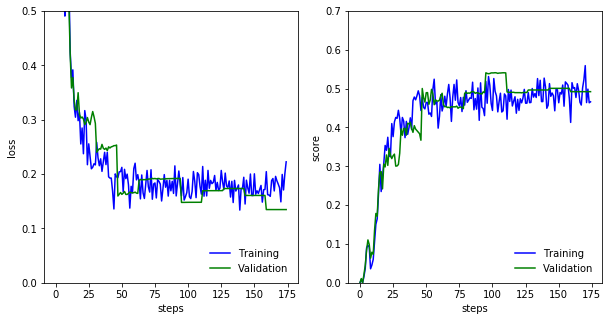

In [28]:
u_net = NeuralNetwork()
sess = u_net.load_session_from_file(nn_name)
sess.close()
train_loss = u_net.params['train_loss']
valid_loss = u_net.params['valid_loss']
train_score = u_net.params['train_score']
valid_score = u_net.params['valid_score']

print('final train/valid loss = {:.4f}/{:.4f}'.format(train_loss[-1], valid_loss[-1]))
print('final train/valid score = {:.4f}/{:.4f}'.format(train_score[-1], valid_score[-1]))
plt.figure(figsize=(10, 5));
plt.subplot(1,2,1)
plt.plot(np.arange(0,len(train_loss)), train_loss,'-b', label='Training')
plt.plot(np.arange(0,len(valid_loss)), valid_loss,'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(top = 0.5, bottom = 0.0)
plt.ylabel('loss')
plt.xlabel('steps');

plt.subplot(1,2,2);
plt.plot(np.arange(0,len(train_score)), train_score,'-b', label='Training')
plt.plot(np.arange(0,len(valid_score)), valid_score,'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(top = 0.7, bottom = 0.0)
plt.ylabel('score')
plt.xlabel('steps');

### IMAGE |  MASK | PREDICTION

In [106]:
cv_num = 2
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=42)

In [107]:
for i,(train_index, valid_index) in enumerate(kfold.split(X_train_balanced)):
    print("## Kfold id:" + str(i))
    # Start timer
    if i==1:
        # Split into train and validation 
        x_trn = X_train_balanced[train_index]
        y_trn = Y_train_balanced[train_index]

        x_vld = X_train_balanced[valid_index]
        y_vld = Y_train_balanced[valid_index]

## Kfold id:0
## Kfold id:1


In [108]:
nn_name = "unet-malaria_256_256_201908040034_trophozoite"

In [109]:
u_net = NeuralNetwork()
sess = u_net.load_session_from_file(nn_name, allow_growth=True)

INFO:tensorflow:Restoring parameters from unet-malaria_256_256_201908040034_trophozoite
Parameters of the loaded neural network
	nn_name = unet-malaria_256_256_201908040034_trophozoite, epoch = 165.17, mb_size = 16
	input_shape = (256, 256, 3), output_shape = (256, 256, 1)
	learn_rate = 0.0000000001, learn_rate_0 = 0.0010000000, dropout_proba = 0.1
	learn_rate_step = 3, learn_rate_pos = 55, learn_rate_alpha = 0.25


### Overall score on train set.

X_train_balanced
Y_train_balanced

In [110]:
y_train_pred = trsf_proba_to_binary(u_net.get_prediction(sess, x_trn))
train_score = get_score(y_trn, y_train_pred)
tmp = np.concatenate([train_index.reshape(-1,1), train_score.reshape(-1,1)], axis=1)
train_score_df = pd.DataFrame(tmp, columns=(['train_index','train_score']))
print(train_score_df.describe())
print('')
print(train_score_df.sort_values(by='train_score', ascending=True).head())

       train_index  train_score
count   298.000000   298.000000
mean    286.758389     0.456627
std     174.304395     0.229152
min       0.000000     0.000000
25%     137.750000     0.263336
50%     285.000000     0.448452
75%     432.750000     0.691667
max     595.000000     0.900000

     train_index  train_score
37          66.0          0.0
253        501.0          0.0
21          31.0          0.0
106        199.0          0.0
47          79.0          0.0


### Overall score on validation set.


             index  valid_index  valid_score
count  298.000000   298.000000   298.000000
mean   148.500000   308.241611     0.502354
std     86.169407   169.671068     0.217014
min      0.000000     1.000000     0.000000
25%     74.250000   160.250000     0.334253
50%    148.500000   314.500000     0.500000
75%    222.750000   459.750000     0.700000
max    297.000000   593.000000     0.900000

      index  valid_index  valid_score
31    31.0         74.0     0.000000
288  288.0        574.0     0.000000
183  183.0        386.0     0.000000
56    56.0        127.0     0.050000
245  245.0        496.0     0.066667


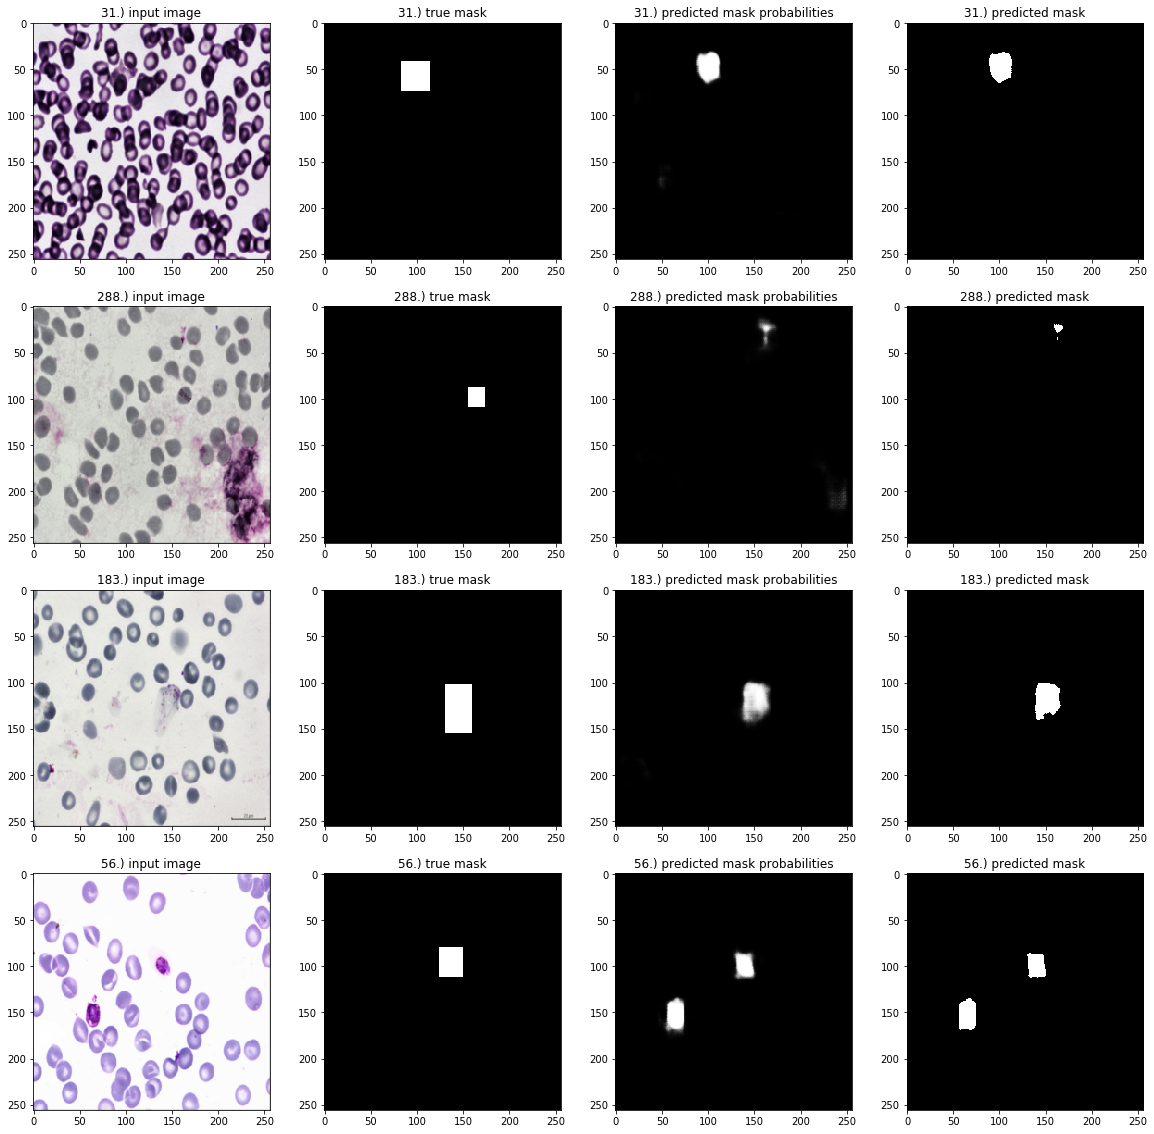

In [111]:
y_valid_pred_proba = u_net.get_prediction(sess, x_vld)
y_valid_pred = trsf_proba_to_binary(y_valid_pred_proba)
valid_score = get_score(y_vld, y_valid_pred)
tmp = np.concatenate([np.arange(len(valid_index)).reshape(-1,1),
                      valid_index.reshape(-1,1),
                      valid_score.reshape(-1,1)], axis=1)
valid_score_df = pd.DataFrame(tmp, columns=(['index', 'valid_index','valid_score']))
print('\n', valid_score_df.describe())
print('\n', valid_score_df.sort_values(by='valid_score', ascending=True).head())

# Plot the worst 4 predictions.
fig, axs = plt.subplots(4,4,figsize=(20,20))
list_ = valid_score_df.sort_values(by='valid_score', ascending=True)[:4]['index'].values.astype(np.int)
#list_ = [valid_score_df['valid_score'].idxmin(),valid_score_df['valid_score'].idxmax()]
for i,n in enumerate(list_):
    img, img_type = imshow_args(x_vld[n])
    axs[i,0].imshow(img, img_type)
    axs[i,0].set_title('{}.) input image'.format(n))
    axs[i,1].imshow(y_vld[n,:,:,0], cm.gray)
    axs[i,1].set_title('{}.) true mask'.format(n))
    axs[i,2].imshow(y_valid_pred_proba[n,:,:,0], cmap='gray') 
    axs[i,2].set_title('{}.) predicted mask probabilities'.format(n))
    axs[i,3].imshow(y_valid_pred[n,:,:,0], cmap='gray') 
    axs[i,3].set_title('{}.) predicted mask'.format(n));

sess.close()

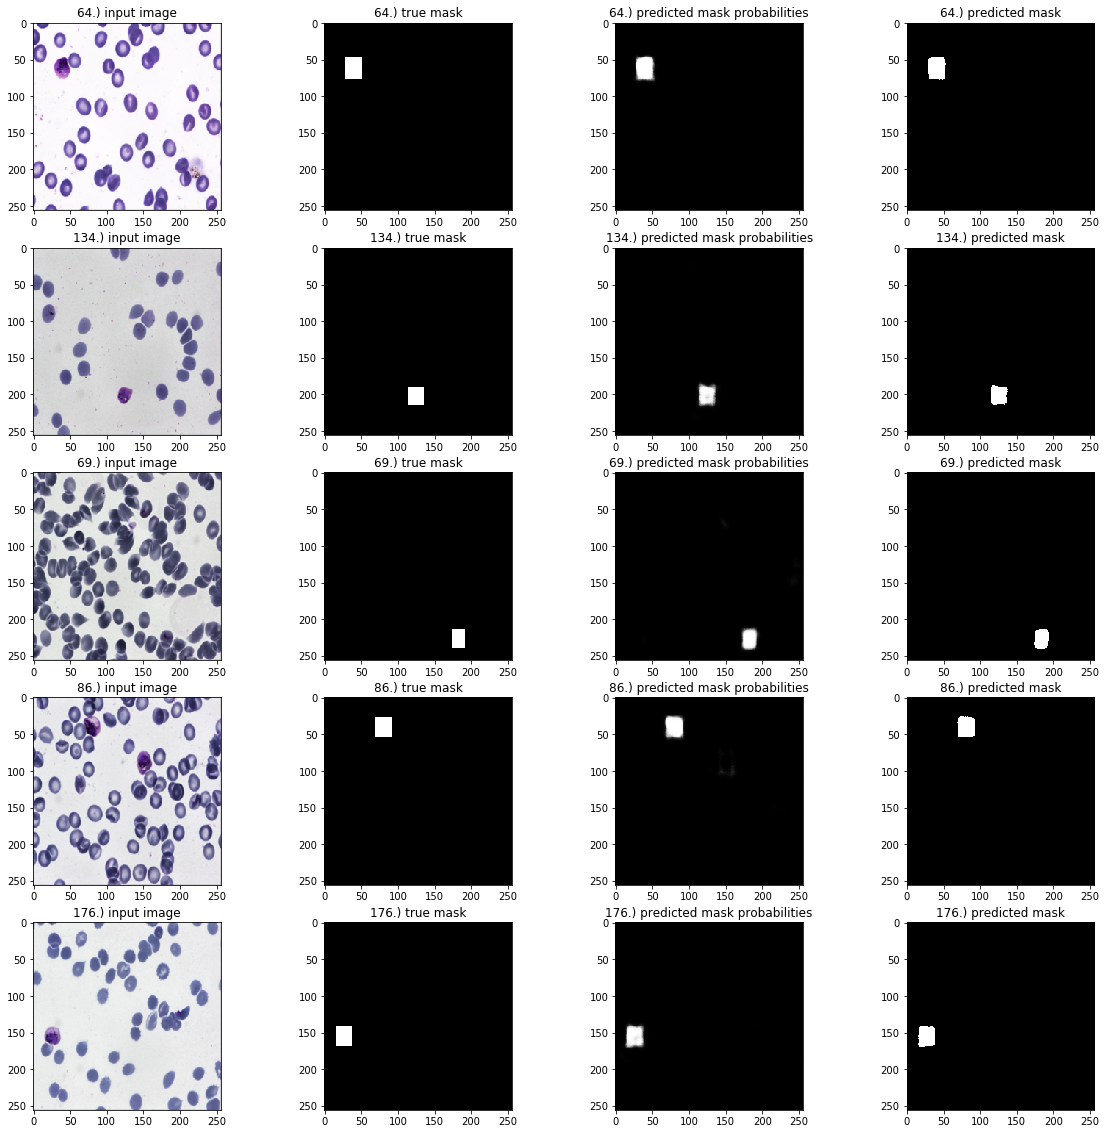

In [112]:
# Plot the best 5 predictions.
fig, axs = plt.subplots(5,4,figsize=(20,20))
list_ = valid_score_df.sort_values(by='valid_score', ascending=False)[:5]['index'].values.astype(np.int)
#list_ = [valid_score_df['valid_score'].idxmin(),valid_score_df['valid_score'].idxmax()]
for i,n in enumerate(list_):
    img, img_type = imshow_args(x_vld[n])
    axs[i,0].imshow(img, img_type)
    axs[i,0].set_title('{}.) input image'.format(n))
    axs[i,1].imshow(y_vld[n,:,:,0], cm.gray)
    axs[i,1].set_title('{}.) true mask'.format(n))
    axs[i,2].imshow(y_valid_pred_proba[n,:,:,0], cmap='gray') 
    axs[i,2].set_title('{}.) predicted mask probabilities'.format(n))
    axs[i,3].imshow(y_valid_pred[n,:,:,0], cmap='gray') 
    axs[i,3].set_title('{}.) predicted mask'.format(n));

sess.close()

# TEST DATA SET

- X_test
- Y_test

In [100]:
u_net = NeuralNetwork()
sess = u_net.load_session_from_file(nn_name, allow_growth=True)

INFO:tensorflow:Restoring parameters from unet-malaria_256_256_201908040034_trophozoite
Parameters of the loaded neural network
	nn_name = unet-malaria_256_256_201908040034_trophozoite, epoch = 165.17, mb_size = 16
	input_shape = (256, 256, 3), output_shape = (256, 256, 1)
	learn_rate = 0.0000000001, learn_rate_0 = 0.0010000000, dropout_proba = 0.1
	learn_rate_step = 3, learn_rate_pos = 55, learn_rate_alpha = 0.25


In [101]:
valid_index = np.arange(0,X_test.shape[0])

In [102]:
y_valid_pred_proba = u_net.get_prediction(sess, X_test)
y_valid_pred = trsf_proba_to_binary(y_valid_pred_proba)
valid_score = get_score(Y_test, y_valid_pred)

tmp = np.concatenate([np.arange(len(valid_index)).reshape(-1,1),
                      valid_index.reshape(-1,1),
                      valid_score.reshape(-1,1)], axis=1)
valid_score_df = pd.DataFrame(tmp, columns=(['index', 'valid_index','valid_score']))
print('\n', valid_score_df.describe())
print('\n', valid_score_df.sort_values(by='valid_score', ascending=True).head())




             index  valid_index  valid_score
count  120.000000   120.000000   120.000000
mean    59.500000    59.500000     0.089344
std     34.785054    34.785054     0.156854
min      0.000000     0.000000     0.000000
25%     29.750000    29.750000     0.000000
50%     59.500000    59.500000     0.000000
75%     89.250000    89.250000     0.136364
max    119.000000   119.000000     0.800000

      index  valid_index  valid_score
119  119.0        119.0          0.0
57    57.0         57.0          0.0
97    97.0         97.0          0.0
55    55.0         55.0          0.0
54    54.0         54.0          0.0


### Plot the worst 5 predictions.

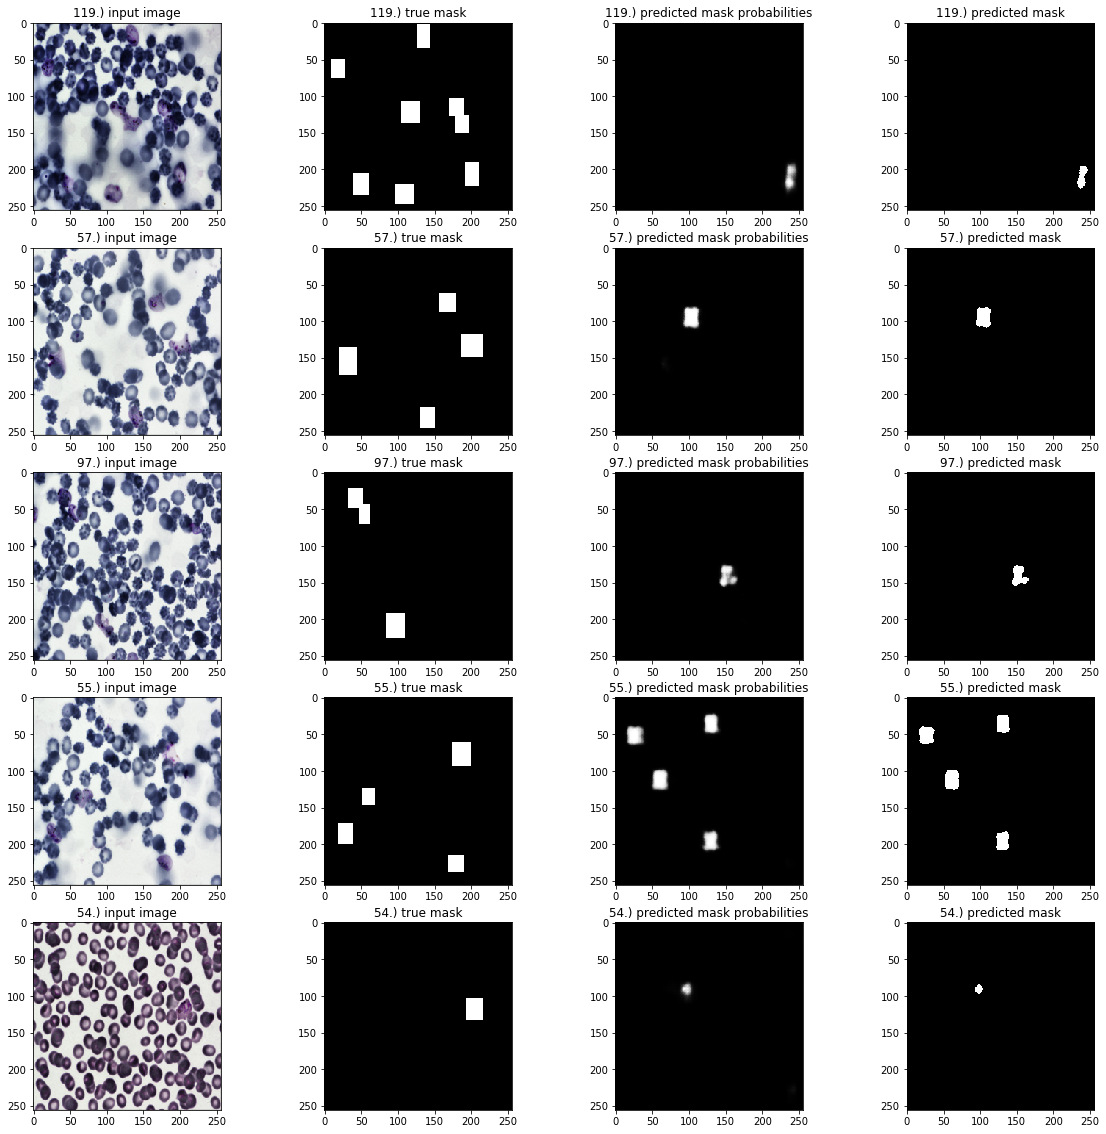

In [103]:
fig, axs = plt.subplots(5,4,figsize=(20,20))
list_ = valid_score_df.sort_values(by='valid_score', ascending=True)[:5]['index'].values.astype(np.int)

for i,n in enumerate(list_):
    img, img_type = imshow_args(x_vld[n])
    axs[i,0].imshow(img, img_type)
    axs[i,0].set_title('{}.) input image'.format(n))
    axs[i,1].imshow(y_vld[n,:,:,0], cm.gray)
    axs[i,1].set_title('{}.) true mask'.format(n))
    axs[i,2].imshow(y_valid_pred_proba[n,:,:,0], cmap='gray') 
    axs[i,2].set_title('{}.) predicted mask probabilities'.format(n))
    axs[i,3].imshow(y_valid_pred[n,:,:,0], cmap='gray') 
    axs[i,3].set_title('{}.) predicted mask'.format(n));

### Plot the best 10 predictions.

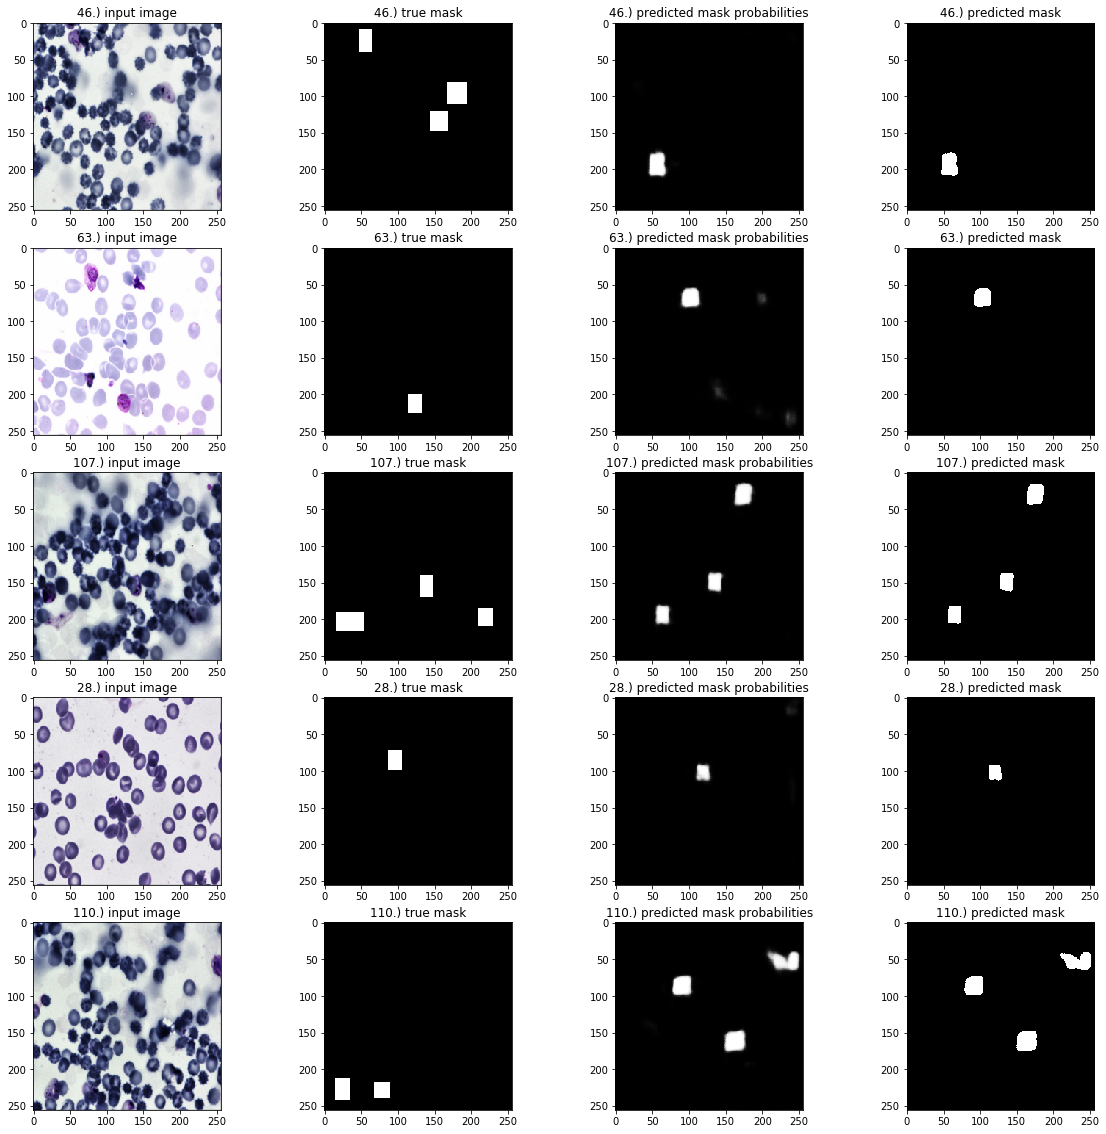

In [104]:
n = 5
fig, axs = plt.subplots(n,4,figsize=(20,20))
list_ = valid_score_df.sort_values(by='valid_score', ascending=False)[:n]['index'].values.astype(np.int)
#list_ = [valid_score_df['valid_score'].idxmin(),valid_score_df['valid_score'].idxmax()]
for i,n in enumerate(list_):
    img, img_type = imshow_args(x_vld[n])
    axs[i,0].imshow(img, img_type)
    axs[i,0].set_title('{}.) input image'.format(n))
    axs[i,1].imshow(y_vld[n,:,:,0], cm.gray)
    axs[i,1].set_title('{}.) true mask'.format(n))
    axs[i,2].imshow(y_valid_pred_proba[n,:,:,0], cmap='gray') 
    axs[i,2].set_title('{}.) predicted mask probabilities'.format(n))
    axs[i,3].imshow(y_valid_pred[n,:,:,0], cmap='gray') 
    axs[i,3].set_title('{}.) predicted mask'.format(n));

In [105]:
sess.close()